# **<center>Imports</center>**

In [459]:
#Network
from keras.layers import Conv2D, UpSampling2D, Input, MaxPooling2D, BatchNormalization, LeakyReLU, Flatten
from keras.layers import concatenate
from keras.callbacks import LearningRateScheduler, EarlyStopping
from keras.optimizers import Adam, SGD, Adadelta, Lion, Nadam, Ftrl, AdamW
from keras.losses import MeanSquaredError
from keras.models import Model
import tensorflow as tf
import pandas as pd
import numpy as np

#Images
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb
from skimage.transform import resize
import matplotlib.pyplot as plt
from skimage.io import imsave
import cv2

#Utilities
from kaggle.api.kaggle_api_extended import KaggleApi
from sklearn.model_selection import train_test_split
from cutecharts.charts import Line
from urllib.request import urlopen
import requests
import warnings
import io
import os

warnings.filterwarnings("ignore")

# **<center>Data Collection</center>**

In [ ]:
def prepareInputData(path, h, w):
    X=[]
    y=[]
    for imageDir in os.listdir(path):
        try:
            img = cv2.imread(path + imageDir)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    
            img = img.astype(np.float32)
            img_lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
            # resize the lightness channel to network input size 
            img_lab_rs = cv2.resize(img_lab, (w, h)) # resize image to network input size
            img_l = img_lab_rs[:,:,0] # pull out L channel
            img_ab = img_lab_rs[:,:,1:]#Extracting the ab channel
            img_ab = img_ab/128
            #The true color values range between -128 and 128. This is the default interval 
            #in the Lab color space. By dividing them by 128, they too fall within the -1 to 1 interval.
            X.append(img_l)
            y.append(img_ab)
        except:
            pass
    X = np.array(X)
    y = np.array(y)
    
    return X,y

In [ ]:
X, y = prepareInputData("datasets/landscapes/", 256, 256)

In [ ]:
X_train = X[:int(len(X)*0.8)]
X_test = X[int(len(X)*0.8):]
y_train = y[:int(len(y)*0.8)]
y_test = y[:int(len(y)*0.8)]

In [ ]:
len(X_train)

3454

In [ ]:
len(X_test)

864

In [206]:
def downloadRawData():
    """
    Obtains data from Kaggle using the API. Only run once (or if you need to
    redownload for some reason).
    """
    api = KaggleApi()
    api.authenticate()

    dataset_name = "vishalsubbiah/pokemon-images-and-types"

    if not os.path.exists("pokemon"):
        os.mkdir("pokemon")

    api.dataset_download_files(dataset_name , path="pokemon1", unzip=True)

# **<center>Making the Model</center>**

In [ ]:
def createModel(networkInput):
    my_model = Conv2D(16,(3,3),padding='same',strides=1)(networkInput)
    my_model = LeakyReLU()(my_model)
    my_model = BatchNormalization()(my_model)
 #   my_model = MaxPooling2D(pool_size=(2,2),padding='same')(my_model)

    #128, 128, 16 with max pooling
    #256, 256, 16 with max pooling


    my_model = Conv2D(32,(3,3),padding='same',strides=1)(my_model)
    my_model = LeakyReLU()(my_model)
    my_model = BatchNormalization()(my_model)
#    my_model = MaxPooling2D(pool_size=(2,2),padding='same')(my_model)

    print(my_model)
    print(networkInput)

    #256, 256, 32 without both, 128, 128, 32 with just first one
    #64, 64, 32 with both, 128, 128, 32 with just second one. 

    
#    my_model = Conv2D(64,(3,3),padding='same',strides=1)(my_model)
#    my_model = LeakyReLU()(my_model)
#    my_model = BatchNormalization()(my_model)
#    my_model = MaxPooling2D(pool_size=(2,2),padding='same')(my_model)
    
#    my_model = Conv2D(128,(3,3),padding='same',strides=1)(my_model)
#    my_model = LeakyReLU()(my_model)
#    my_model = BatchNormalization()(my_model)
    
#    my_model = Conv2D(256,(3,3),padding='same',strides=1)(my_model)
#    my_model = LeakyReLU()(my_model)
#    my_model = BatchNormalization()(my_model)

    #32, 32, 256
    
#    my_model = UpSampling2D((2, 2))(my_model)

    #64, 64, 256

    my_model = Conv2D(128,(3,3),padding='same',strides=1)(my_model)
    my_model = LeakyReLU()(my_model)
    my_model = BatchNormalization()(my_model)

    #64, 64, 128
    
  #  my_model = UpSampling2D((2, 2))(my_model)
    my_model = Conv2D(64,(3,3), padding='same',strides=1)(my_model)
    my_model = LeakyReLU()(my_model)
    my_model = BatchNormalization()(my_model)

    #128, 128, 64

#    my_model = UpSampling2D((2, 2))(my_model)
    my_model = Conv2D(32,(3,3), padding='same',strides=1)(my_model)
    my_model = LeakyReLU()(my_model)
    my_model = BatchNormalization()(my_model)

    print(my_model)
    print(networkInput)
    
    concat_ = concatenate([my_model, networkInput]) 
    
    my_model = Conv2D(64,(3,3), padding='same',strides=1)(concat_)
    my_model = LeakyReLU()(my_model)
    my_model = BatchNormalization()(my_model)
    
    my_model = Conv2D(32,(3,3),padding='same',strides=1)(my_model)
    my_model = LeakyReLU()(my_model)
    my_model = BatchNormalization()(my_model)
    
    my_model = Conv2D(2,(3,3), activation='tanh',padding='same',strides=1)(my_model)

    return my_model


In [ ]:
def createModelTwo(networkInput):
    my_model = Conv2D(16,(3,3),padding='same',strides=1)(networkInput)
    my_model = LeakyReLU()(my_model)
    my_model = BatchNormalization()(my_model)

    my_model = Conv2D(32,(3,3),padding='same',strides=1)(networkInput)
    my_model = LeakyReLU()(my_model)
    my_model = BatchNormalization()(my_model)

    my_model = Conv2D(64,(3,3),padding='same',strides=1)(networkInput)
    my_model = LeakyReLU()(my_model)
    my_model = BatchNormalization()(my_model)

    my_model = Conv2D(128,(3,3),padding='same',strides=1)(networkInput)
    my_model = LeakyReLU()(my_model)
    my_model = BatchNormalization()(my_model)

    my_model = Conv2D(256,(3,3),padding='same',strides=1)(networkInput)
    my_model = LeakyReLU()(my_model)
    my_model = BatchNormalization()(my_model)

    my_model = Conv2D(512,(3,3),padding='same',strides=1)(networkInput)
    my_model = LeakyReLU()(my_model)
    my_model = BatchNormalization()(my_model)

#    my_model = MaxPooling2D(pool_size=(2,2),padding='same')(my_model)

#    my_model = Conv2D(512,(3,3),padding='same',strides=1)(networkInput)
 #   my_model = LeakyReLU()(my_model)
  #  my_model = BatchNormalization()(my_model)

    my_model = Conv2D(256,(3,3),padding='same',strides=1)(networkInput)
    my_model = LeakyReLU()(my_model)
    my_model = BatchNormalization()(my_model)

    my_model = Conv2D(128,(3,3),padding='same',strides=1)(networkInput)
    my_model = LeakyReLU()(my_model)
    my_model = BatchNormalization()(my_model)

    my_model = Conv2D(64,(3,3),padding='same',strides=1)(networkInput)
    my_model = LeakyReLU()(my_model)
    my_model = BatchNormalization()(my_model)

    my_model = Conv2D(32,(3,3),padding='same',strides=1)(networkInput)
    my_model = LeakyReLU()(my_model)
    my_model = BatchNormalization()(my_model)

    my_model = Conv2D(16,(3,3),padding='same',strides=1)(networkInput)
    my_model = LeakyReLU()(my_model)
    my_model = BatchNormalization()(my_model)

    my_model = Conv2D(64,(3,3),padding='same',strides=1)(networkInput)
    my_model = LeakyReLU()(my_model)
    my_model = BatchNormalization()(my_model)


    my_model = Conv2D(2,(3,3), activation='tanh',padding='same',strides=1)(my_model)

    return my_model


In [ ]:
networkInput = Input(shape=(256, 256,1))
networkOutput = createModelTwo(networkInput)
model = Model(inputs=networkInput, outputs=networkOutput)

In [ ]:
networkInputTwo = Input(shape=(256, 256, 1))
networkOutputTwo = createModelTwo(networkInputTwo)
model2 = Model(inputs=networkInputTwo, outputs=networkOutputTwo)

In [ ]:
def custom_loss(y_true, y_pred):
    # Split the predicted and ground truth tensors into a and b channels
    a_true, b_true = tf.split(y_true, num_or_size_splits=2, axis=-1)
    a_pred, b_pred = tf.split(y_pred, num_or_size_splits=2, axis=-1)
    
    # Compute the Euclidean distance between a and b channels 4
    color_loss = tf.sqrt(tf.square(a_true - a_pred) + tf.square(b_true - b_pred))
    
    # Compute hue and saturation from a and b channels of predicted image
    hue_true = tf.math.atan2(b_true, a_true) #-pi to pi
    saturation_true = tf.sqrt(tf.square(a_true) + tf.square(b_true)) 
    hue_pred = tf.math.atan2(b_pred, a_pred)
    saturation_pred = tf.sqrt(tf.square(a_pred) + tf.square(b_pred))
    
    # Define the weighting factor for emphasizing saturation over hue
    saturation_weight = 3.0
    
    # Compute the weighted hue-saturation loss
    hue_saturation_loss = tf.square(hue_pred - hue_true) + saturation_weight * tf.square(saturation_pred - saturation_true)
    
    # Combine the color loss and hue-saturation loss
    total_loss = tf.add(color_loss,hue_saturation_loss)
    
    # Return the mean loss over the batch
    return tf.reduce_mean(tf.sqrt(hue_saturation_loss))


In [ ]:
def hue_bin_loss(y_true, y_pred):
    a_true, b_true = tf.split(y_true, num_or_size_splits=2, axis=-1)
    a_pred, b_pred = tf.split(y_pred, num_or_size_splits=2, axis=-1)

    condition1 = tf.logical_and(tf.less(y_true, 0), tf.less(y_pred, 0))
    condition2 = tf.logical_and(tf.greater(y_true, 0), tf.greater(y_pred, 0))

    hl = tf.where(condition1 | condition2, 0.0, tf.abs(y_pred - y_true))

    saturation_true = tf.sqrt(tf.square(a_true) + tf.square(b_true))
    saturation_pred = tf.sqrt(tf.square(a_pred) + tf.square(b_pred))
    sl = tf.abs(saturation_true - saturation_pred)

    color_loss = tf.sqrt(tf.square(a_true - a_pred) + tf.square(b_true - b_pred))
    total_loss = tf.add(color_loss, (0.75*hl + sl))

    return tf.reduce_mean(0.5*hl + sl)  # Use reduce_mean to ensure a scalar loss value


In [ ]:
def custom_hue_loss(y_true, y_pred):
    condition1 = tf.logical_and(tf.less(y_true, 0), tf.less(y_pred, 0))
    condition2 = tf.logical_and(tf.greater(y_true, 0), tf.greater(y_pred, 0))

    hl = tf.where(condition1 | condition2, 0.0, 0.1 * tf.abs(y_pred - y_true))

    return hl


In [441]:
LEARNING_RATE = 0.001
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
                            loss=hue_bin_loss)
model.summary()

Model: "model_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_39 (InputLayer)       [(None, 256, 256, 1)]     0         
                                                                 
 conv2d_505 (Conv2D)         (None, 256, 256, 64)      640       
                                                                 
 leaky_re_lu_467 (LeakyReLU  (None, 256, 256, 64)      0         
 )                                                               
                                                                 
 batch_normalization_467 (B  (None, 256, 256, 64)      256       
 atchNormalization)                                              
                                                                 
 conv2d_506 (Conv2D)         (None, 256, 256, 2)       1154      
                                                                 
Total params: 2050 (8.01 KB)
Trainable params: 1922 (7.51 

In [442]:
model2.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss="mse"
)

In [443]:
NUM_EPOCHS = 300
NUM_STEPS = round(len(X_train)/NUM_EPOCHS)-1
VAL_STEPS = round(len(X_test)//NUM_EPOCHS)-1

In [444]:
NUM_STEPS

11

In [445]:
def GenerateInputs(X_,y_):
    for i in range(len(X_)):
        X_input = X_[i].reshape(1,256,256,1)
        y_input = y_[i].reshape(1,256,256,2)
        yield (X_input,y_input)

history = model.fit(GenerateInputs(X_train,y_train),epochs=NUM_EPOCHS,verbose=1, steps_per_epoch=NUM_STEPS, shuffle=True,validation_data=GenerateInputs(X_test, y_test), validation_steps=VAL_STEPS)

Epoch 1/300
 1/11 [=>............................] - ETA: 3s - loss: 0.2310

2024-01-05 16:44:06.298537: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 1s 27ms/step - loss: 0.1007 - val_loss: 1.8974
Epoch 2/300
 6/11 [===============>..............] - ETA: 0s - loss: 0.0678

2024-01-05 16:44:06.650996: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 0s 13ms/step - loss: 0.1651 - val_loss: 1.9065
Epoch 3/300
11/11 [==============================] - 0s 15ms/step - loss: 0.1283 - val_loss: 1.9019
Epoch 4/300
11/11 [==============================] - 0s 14ms/step - loss: 0.1939 - val_loss: 1.8143
Epoch 5/300
11/11 [==============================] - 0s 15ms/step - loss: 0.1203 - val_loss: 1.2778
Epoch 6/300
11/11 [==============================] - 0s 16ms/step - loss: 0.0574 - val_loss: 1.9011
Epoch 7/300
11/11 [==============================] - 0s 15ms/step - loss: 0.0766 - val_loss: 1.4474
Epoch 8/300
11/11 [==============================] - 0s 14ms/step - loss: 0.0775 - val_loss: 1.8720
Epoch 9/300
11/11 [==============================] - 0s 14ms/step - loss: 0.1031 - val_loss: 1.6929
Epoch 10/300
11/11 [==============================] - 0s 14ms/step - loss: 0.1113 - val_loss: 1.3203
Epoch 11/300
11/11 [==============================] - 0s 13ms/step - loss: 0.1060 - val_loss: 1.5254
Epoch 12/3

2024-01-05 16:44:51.573091: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 5743684660120303807
2024-01-05 16:44:51.573113: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 6276639929041978693
2024-01-05 16:44:51.573122: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 9995856745810218078


11/11 [==============================] - 0s 16ms/step - loss: 0.0212
Epoch 290/300
11/11 [==============================] - 0s 13ms/step - loss: 0.0125
Epoch 291/300
11/11 [==============================] - 0s 14ms/step - loss: 0.0103
Epoch 292/300
11/11 [==============================] - 0s 13ms/step - loss: 0.0115
Epoch 293/300
11/11 [==============================] - 0s 13ms/step - loss: 0.0459
Epoch 294/300
11/11 [==============================] - 0s 14ms/step - loss: 0.0632
Epoch 295/300
11/11 [==============================] - 0s 13ms/step - loss: 0.0832
Epoch 296/300
11/11 [==============================] - 0s 14ms/step - loss: 0.0481
Epoch 297/300
11/11 [==============================] - 0s 13ms/step - loss: 0.0511
Epoch 298/300
11/11 [==============================] - 0s 13ms/step - loss: 0.0538
Epoch 299/300
11/11 [==============================] - 0s 13ms/step - loss: 0.0147
Epoch 300/300
11/11 [==============================] - 0s 13ms/step - loss: 0.0083


In [446]:
history_model_two = model2.fit(GenerateInputs(X_train, y_train), epochs=NUM_EPOCHS, verbose=1, steps_per_epoch=NUM_STEPS, shuffle=True, validation_data=GenerateInputs(X_test, y_test), validation_steps=VAL_STEPS)

Epoch 1/300
 6/11 [===============>..............] - ETA: 0s - loss: 0.0317

2024-01-05 16:45:00.848549: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 0s 18ms/step - loss: 0.0303 - val_loss: 0.9952
Epoch 2/300
11/11 [==============================] - 0s 13ms/step - loss: 0.0560 - val_loss: 0.9979
Epoch 3/300
 1/11 [=>............................] - ETA: 0s - loss: 0.0807

2024-01-05 16:45:01.098166: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 0s 11ms/step - loss: 0.0436 - val_loss: 0.9989
Epoch 4/300
11/11 [==============================] - 0s 11ms/step - loss: 0.0764 - val_loss: 0.2847
Epoch 5/300
11/11 [==============================] - 0s 11ms/step - loss: 0.0421 - val_loss: 0.8841
Epoch 6/300
11/11 [==============================] - 0s 12ms/step - loss: 0.0257 - val_loss: 0.9979
Epoch 7/300
11/11 [==============================] - 0s 12ms/step - loss: 0.0277 - val_loss: 0.7431
Epoch 8/300
11/11 [==============================] - 0s 12ms/step - loss: 0.0252 - val_loss: 0.6350
Epoch 9/300
11/11 [==============================] - 0s 11ms/step - loss: 0.0269 - val_loss: 0.9568
Epoch 10/300
11/11 [==============================] - 0s 11ms/step - loss: 0.0226 - val_loss: 0.8344
Epoch 11/300
11/11 [==============================] - 0s 11ms/step - loss: 0.0387 - val_loss: 0.9687
Epoch 12/300
11/11 [==============================] - 0s 12ms/step - loss: 0.1173 - val_loss: 0.5180
Epoch 13/

2024-01-05 16:45:38.335714: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 6276639929041978693
2024-01-05 16:45:38.335725: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 7988592932925168044
2024-01-05 16:45:38.335732: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 13968925830440552844


11/11 [==============================] - 0s 11ms/step - loss: 0.0014
Epoch 290/300
11/11 [==============================] - 0s 11ms/step - loss: 8.2724e-04
Epoch 291/300
11/11 [==============================] - 0s 11ms/step - loss: 4.8915e-04
Epoch 292/300
11/11 [==============================] - 0s 11ms/step - loss: 8.6571e-04
Epoch 293/300
11/11 [==============================] - 0s 11ms/step - loss: 9.7024e-04
Epoch 294/300
11/11 [==============================] - 0s 11ms/step - loss: 9.1096e-04
Epoch 295/300
11/11 [==============================] - 0s 10ms/step - loss: 0.0011
Epoch 296/300
11/11 [==============================] - 0s 10ms/step - loss: 0.0014
Epoch 297/300
11/11 [==============================] - 0s 10ms/step - loss: 0.0013
Epoch 298/300
11/11 [==============================] - 0s 11ms/step - loss: 0.0013
Epoch 299/300
11/11 [==============================] - 0s 11ms/step - loss: 1.7135e-04
Epoch 300/300
11/11 [==============================] - 0s 11ms/step - loss: 1

In [658]:
data = {
 #   "acc": list(history.history["acc"]),
#    "val_acc": list(history.history["val_acc"]),
    "loss": list(history.history["loss"]),
    "val_loss": list(history.history["val_loss"])
}

In [299]:
chart = Line("Model Results")
chart.set_options(
    labels=list(range(50)),
    x_label="Epoch",
    y_label="Percent",
)


#chart.add_series("acc", data["acc"])
#chart.add_series("val_acc", data["val_acc"])
chart.add_series("loss", data["loss"])
chart.add_series("val_loss", data["val_loss"])
#chart.render_notebook()
chart.render_notebook()

# **<center>Testing the Model</center>**

In [334]:
def ExtractTestInput(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
#    img_ = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    img_ = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    img_=img.astype(np.float32)
    img_lab_rs = cv2.resize(img_, (256, 256)) # resize image to network input size
    img_l = img_lab_rs[:,:,0] # pull out L channel
    img_l_reshaped = img_l.reshape(1,256,256,1)
    
    return img_l_reshaped

1/1 [==============================] - 0s 11ms/step


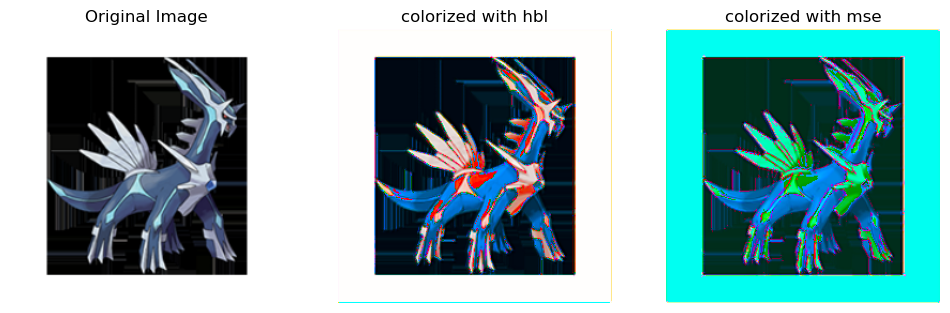

In [450]:
# Load a sample test image
TestImagePath = "datasets/pokemon/POKEMON/0483.png"
img = cv2.imread(TestImagePath)
img = cv2.resize(img, (256, 256))

# Extract test input
image_for_test = ExtractTestInput(img)

# Make a prediction using the trained model
model_one_pred = model.predict(image_for_test)
model_one_pred = model_one_pred * 128
model_one_pred = model_one_pred.reshape(256, 256, 2)

model_two_pred = model2.predict(image_for_test)
model_two_pred = model_two_pred * 128
model_two_pred = model_two_pred.reshape(256, 256, 2)

img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)

comp_hbl = img_lab.copy()
comp_hbl[:, :, 1:] = model_one_pred
comp_hbl = cv2.cvtColor(comp_hbl, cv2.COLOR_Lab2RGB)

comp_mse = img_lab.copy()
comp_mse[:, :, 1:] = model_two_pred
comp_mse = cv2.cvtColor(comp_mse, cv2.COLOR_Lab2RGB)

plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)

# Plotting the original image
img_original = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_original)
plt.title("Original Image")
plt.axis('off')

# Plotting HBL Image
plt.subplot(1, 3, 2)
plt.imshow(comp_hbl)
plt.title("colorized with hbl")
plt.axis('off')

# Plotting MSE Image
plt.subplot(1, 3, 3)
plt.imshow(comp_mse)
plt.title("colorized with mse")
plt.axis('off')

plt.show()
plt.close()


1/1 [==============================] - 0s 11ms/step


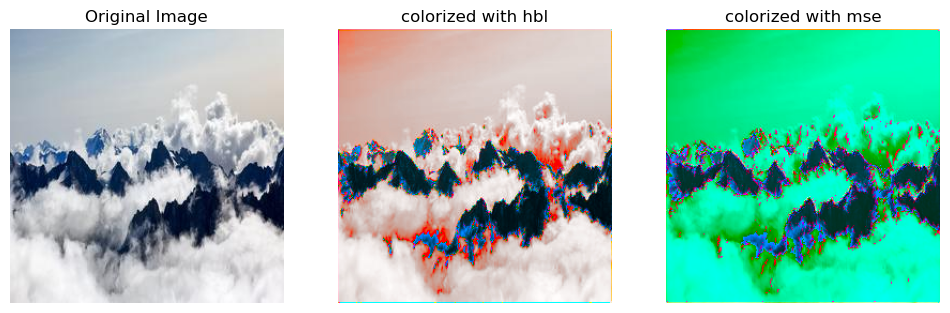

In [454]:
# Load a sample test image
TestImagePath = "datasets/unsplash/val/val_data/zODhvByGc74.jpg"
img = cv2.imread(TestImagePath)
img = cv2.resize(img, (256, 256))

# Extract test input
image_for_test = ExtractTestInput(img)

# Make a prediction using the trained model
model_one_pred = model.predict(image_for_test)
model_one_pred = model_one_pred * 128
model_one_pred = model_one_pred.reshape(256, 256, 2)

model_two_pred = model2.predict(image_for_test)
model_two_pred = model_two_pred * 128
model_two_pred = model_two_pred.reshape(256, 256, 2)

img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)

comp_hbl = img_lab.copy()
comp_hbl[:, :, 1:] = model_one_pred
comp_hbl = cv2.cvtColor(comp_hbl, cv2.COLOR_Lab2RGB)

comp_mse = img_lab.copy()
comp_mse[:, :, 1:] = model_two_pred
comp_mse = cv2.cvtColor(comp_mse, cv2.COLOR_Lab2RGB)

plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)

# Plotting the original image
img_original = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_original)
plt.title("Original Image")
plt.axis('off')

# Plotting HBL Image
plt.subplot(1, 3, 2)
plt.imshow(comp_hbl)
plt.title("colorized with hbl")
plt.axis('off')

# Plotting MSE Image
plt.subplot(1, 3, 3)
plt.imshow(comp_mse)
plt.title("colorized with mse")
plt.axis('off')

plt.show()
plt.close()


In [652]:
#model.save(filepath="triple_trained")

INFO:tensorflow:Assets written to: triple_trained/assets


INFO:tensorflow:Assets written to: triple_trained/assets


In [242]:
len(np.unique(Prediction))

62964

In [118]:
from keras.saving import load_model

In [948]:
model.save(filepath="trial.h5")

In [119]:
model1 = load_model("trial.h5", custom_objects={"hue_bin_loss": hue_bin_loss})

In [21]:
# Load a sample test image
TestImagePath = "data/00000075_(4).jpg"
img = cv2.imread(TestImagePath)
img = cv2.resize(img, (256, 256))

# Extract test input
image_for_test = ExtractTestInput(img)

# Make a prediction using the trained model
Prediction = model1.predict(image_for_test)
Prediction = Prediction * 128
Prediction = Prediction.reshape(256, 256, 2)
#loss = image_for_test[:,:,1:]-Prediction
print(image_for_test.shape)

# Create Lab image with L channel from original image and predicted a,b channels
img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)
img_lab_colorized = img_lab.copy()
img_lab_colorized[:, :, 1:] = Prediction

newImg = np.array(image_for_test + Prediction)
#newImg = newImg.reshape(256,256,3)
print(newImg.shape)

# Convert Lab image to RGB
img_colorized = cv2.cvtColor(img_lab_colorized, cv2.COLOR_Lab2RGB)

# Display the images
plt.figure(figsize=(12, 6))

# Original Image
plt.subplot(1, 3, 1)
img_original = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_original)
plt.title("Original Image")
plt.axis('off')

# Colorized Image
plt.subplot(1, 3, 2)
plt.imshow(img_colorized)
plt.title("Colorized Image")
plt.axis('off')

# Ground Truth Image
plt.subplot(1, 3, 3)
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_gray = cv2.cvtColor(img_gray, cv2.COLOR_GRAY2RGB)
plt.imshow(img_gray)
plt.title("Black & White Image")
plt.axis('off')

plt.show()


NameError: name 'model1' is not defined

In [134]:
model1.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
                            loss="mse")


In [135]:
model1.fit(GenerateInputs(X_train,y_train),epochs=NUM_EPOCHS,verbose=1, steps_per_epoch=NUM_STEPS, shuffle=True,validation_data=GenerateInputs(X_test, y_test), validation_steps=VAL_STEPS-2)

Epoch 1/50
 5/69 [=>............................] - ETA: 0s - loss: 1.2360e-04 

2024-01-01 10:44:29.985665: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


69/69 [==============================] - 1s 12ms/step - loss: 7.4427e-05 - val_loss: 3.7675e-05
Epoch 2/50
 6/69 [=>............................] - ETA: 0s - loss: 9.2010e-06

2024-01-01 10:44:30.848777: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


69/69 [==============================] - 1s 11ms/step - loss: 2.6484e-05 - val_loss: 9.3436e-05
Epoch 3/50
69/69 [==============================] - 1s 10ms/step - loss: 3.3572e-05 - val_loss: 1.3932e-05
Epoch 4/50
69/69 [==============================] - 1s 10ms/step - loss: 8.1420e-06 - val_loss: 1.1770e-04
Epoch 5/50
69/69 [==============================] - 1s 10ms/step - loss: 9.4756e-06 - val_loss: 1.5648e-05
Epoch 6/50
69/69 [==============================] - 1s 10ms/step - loss: 5.9782e-06 - val_loss: 1.9761e-05
Epoch 7/50
69/69 [==============================] - 1s 11ms/step - loss: 2.5960e-05 - val_loss: 6.3629e-05
Epoch 8/50
69/69 [==============================] - 1s 11ms/step - loss: 4.2260e-06 - val_loss: 7.0238e-05
Epoch 9/50
69/69 [==============================] - 1s 11ms/step - loss: 1.3416e-04 - val_loss: 9.0082e-05
Epoch 10/50
69/69 [==============================] - 1s 11ms/step - loss: 6.6331e-06 - val_loss: 3.0434e-05
Epoch 11/50
69/69 [============================